In [1]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import re
from sklearn import preprocessing
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering
from matplotlib import pyplot as plt
import pickle

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import tree

from sklearn.metrics import confusion_matrix
from sklearn import tree
import graphviz 
import plotly
import chart_studio.plotly as py

In [2]:
#### leitura dos datasets

df_Cliente_raw = pd.read_csv('FIAP Dataset 1.csv', encoding='utf8')
df_Produto_raw = pd.read_csv('Dataset-3.csv', encoding='utf8')

In [3]:
### tamanho dos dataframes
print(df_Produto_raw.shape)
print(df_Cliente_raw.shape)

(8603, 86)
(52857, 60)


In [4]:
#Merge para coletar cada produto que o cliente possui
df_Cliente_produto = pd.merge(
             df_Cliente_raw[['idade','genero','estadocivil','scorenivelconhecimento','perfilinvestidor','scorerisco','scoreobjetivos','rendamensal','scoresituacaofinanceira','produto']],
             df_Produto_raw[[ 'DescricaoProduto__c','ProdutoId']], 
             how='left',
             left_on='produto',
             right_on='ProdutoId'
        )

In [5]:
print(df_Cliente_produto.shape)

(52857, 12)


In [6]:
#excluindo duplicados
df_Cliente_perfil_stage = df_Cliente_produto.drop_duplicates()
df_Cliente_perfil_stage.shape

(31203, 12)

Text(0.5, 1.0, 'Nulos em cliente')

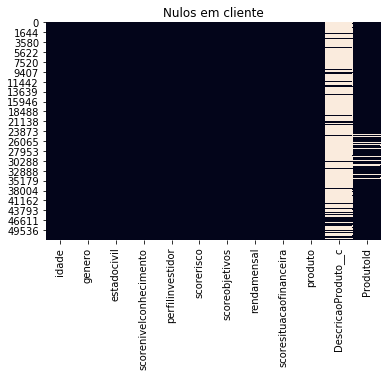

In [7]:
## analisando total de nulos cliente
graf = sns.heatmap(df_Cliente_perfil_stage.isnull(), cbar=False)
graf.set_title('Nulos em cliente')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Text(0.5, 1.0, 'Nulos base final')

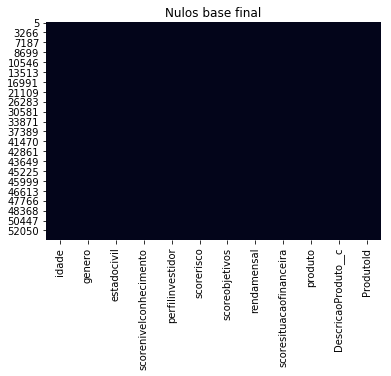

In [8]:
#Excluindo linhas nulas
df_Cliente_perfil_stage.dropna(inplace=True)
graf = sns.heatmap(df_Cliente_perfil_stage.isnull(), cbar=False)
graf.set_title('Nulos base final')

In [9]:
#Tamanho df após exclusão de linhas
df_Cliente_perfil_stage.shape

(5796, 12)

In [10]:
#Excluindo variaveis desnecessárias
df_Cliente_perfil_stage.drop(['produto','ProdutoId'], axis=1, inplace=True)
df_Cliente_perfil_stage.head() 

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,idade,genero,estadocivil,scorenivelconhecimento,perfilinvestidor,scorerisco,scoreobjetivos,rendamensal,scoresituacaofinanceira,DescricaoProduto__c
5,42.6,M,C,5.0,3,2.0,3.0,14000.0,3.0,LCA POS
9,41.7,M,S,3.0,2,2.0,2.0,13000.0,2.0,LCI POS
22,30.5,M,C,1.0,3,4.0,3.0,1900.0,2.0,CDB POS 1
24,59.3,M,S,2.0,2,1.0,2.0,7000.0,3.0,CDB POS 1
27,30.3,F,M,4.0,3,2.0,2.0,2500.0,2.0,LCA POS


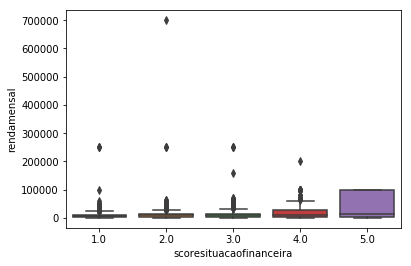

In [11]:
#Correlação entre as variaveis scoresituacaofinanceira e rendamensal
sns.boxplot(x='scoresituacaofinanceira', y='rendamensal', data=df_Cliente_perfil_stage) 

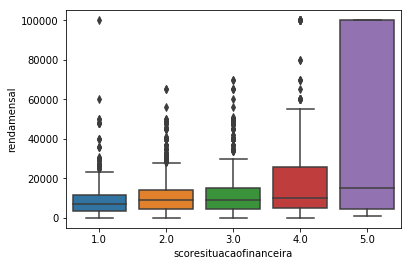

In [12]:
#visualização sem outlayers
sns.boxplot(x='scoresituacaofinanceira', y='rendamensal', data=df_Cliente_perfil_stage[df_Cliente_perfil_stage['rendamensal'] <= 100000])

In [13]:
### One hot encoding da base
df_Cliente_perfil_dummies = pd.get_dummies(df_Cliente_perfil_stage[['genero', 'estadocivil', 'perfilinvestidor','scorenivelconhecimento','scorerisco','scoreobjetivos','scoresituacaofinanceira', 'DescricaoProduto__c', 'idade']], columns= [ 'genero', 'estadocivil', 'perfilinvestidor','scorenivelconhecimento','scorerisco','scoreobjetivos','scoresituacaofinanceira','DescricaoProduto__c'])
df_Cliente_perfil_dummies.shape

(5796, 47)

In [14]:
#Normalizando variavel idade
df_Cliente_perfil_dummies['idade'] = (df_Cliente_perfil_dummies['idade'] - df_Cliente_perfil_dummies['idade'].mean())/df_Cliente_perfil_dummies['idade'].std(ddof=0)
df_Cliente_perfil_dummies.head()

,idade,genero_F,genero_M,estadocivil_C,estadocivil_D,estadocivil_I,estadocivil_M,estadocivil_S,estadocivil_V,perfilinvestidor_1,...,DescricaoProduto__c_CDB PRE,DescricaoProduto__c_CDB PRE 1,DescricaoProduto__c_LC POS,DescricaoProduto__c_LC PRE,DescricaoProduto__c_LCA POS,DescricaoProduto__c_LCA POS 1,DescricaoProduto__c_LCA PRE,DescricaoProduto__c_LCI POS,DescricaoProduto__c_LCI POS 1,DescricaoProduto__c_LCI PRE
5,0.349963,0,1,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
9,0.266990,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
22,-0.765563,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24,1.889573,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
27,-0.784001,1,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [15]:
#Utilizando uma copia do df
df_Cliente_perfil_normalizado = df_Cliente_perfil_dummies
df_Cliente_perfil_normalizado.shape

(5796, 47)

In [16]:
#Clusterizando o perfil do cliente
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=7, random_state=0).fit(df_Cliente_perfil_normalizado)

In [17]:
df_Cliente_perfil_normalizado['cluster'] = kmeans.labels_
df_Cliente_perfil_normalizado.shape

(5796, 48)

In [18]:
#Separando a base para treino e teste
y = df_Cliente_perfil_normalizado[['cluster']]
X = df_Cliente_perfil_normalizado.drop(['cluster'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=777) # 70% training and 30% test

In [19]:
### Treinamento da árvore de decisao
clf = DecisionTreeClassifier(criterion='entropy', random_state=777)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9769982748706153


In [20]:
#Verificando distribuição dos clusteres
df_Cliente_perfil_normalizado.groupby(by='cluster')['cluster'].count()

cluster
0     900
1     834
2     910
3     655
4    1073
5     574
6     850
Name: cluster, dtype: int64

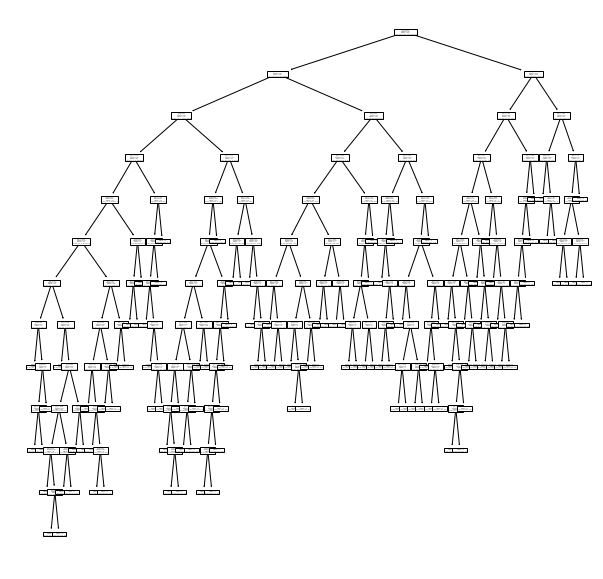

In [21]:
#Printando a árvore gerada
fig, ax = plt.subplots(figsize=(10, 10))  
tree.plot_tree(clf, ax=ax)

plt.rc('font', size=23)

plt.show()

In [22]:
#Printando as escala de importancia para cada variavel na árvore
print(dict(zip(df_Cliente_perfil_normalizado.columns, clf.feature_importances_)))

{'idade': 0.18969028648840305, 'genero_F': 0.0018619737898002474, 'genero_M': 0.002856932800313247, 'estadocivil_C': 0.009847375751350654, 'estadocivil_D': 0.0, 'estadocivil_I': 0.0013764492714109088, 'estadocivil_M': 0.006886018636457492, 'estadocivil_S': 0.2560318332518009, 'estadocivil_V': 0.0, 'perfilinvestidor_1': 0.004600451525329864, 'perfilinvestidor_2': 0.15434977693021393, 'perfilinvestidor_3': 0.2872553260586216, 'perfilinvestidor_4': 0.0004882835822828734, 'perfilinvestidor_5': 0.0, 'scorenivelconhecimento_1.0': 0.0005965970838843459, 'scorenivelconhecimento_2.0': 0.0003853712259664466, 'scorenivelconhecimento_3.0': 0.002428236293480228, 'scorenivelconhecimento_4.0': 0.0006397822706833249, 'scorenivelconhecimento_5.0': 0.023555278004788974, 'scorerisco_1.0': 0.0284868069031917, 'scorerisco_2.0': 0.0082794315344224, 'scorerisco_3.0': 0.0007904742962994116, 'scorerisco_4.0': 0.001014972124725365, 'scorerisco_5.0': 0.0, 'scoreobjetivos_1.0': 0.0, 'scoreobjetivos_2.0': 0.005538

In [24]:
df_Cliente_perfil_stage.head()

,idade,genero,estadocivil,scorenivelconhecimento,perfilinvestidor,scorerisco,scoreobjetivos,rendamensal,scoresituacaofinanceira,DescricaoProduto__c
5,42.6,M,C,5.0,3,2.0,3.0,14000.0,3.0,LCA POS
9,41.7,M,S,3.0,2,2.0,2.0,13000.0,2.0,LCI POS
22,30.5,M,C,1.0,3,4.0,3.0,1900.0,2.0,CDB POS 1
24,59.3,M,S,2.0,2,1.0,2.0,7000.0,3.0,CDB POS 1
27,30.3,F,M,4.0,3,2.0,2.0,2500.0,2.0,LCA POS


In [25]:
#Preparando o df para o gráfico
#Criando faixa etária
print("Maior idade: ", df_Cliente_perfil_stage['idade'].max())
print("Menor idade: ", df_Cliente_perfil_stage['idade'].min())

def calc_faixa_etaria(idade):
    
    if idade >= 18 and idade < 30:
        faixa_etaria = "Jovem(18 - 29)"

    if idade >= 30 and idade < 60:
        faixa_etaria = "Adulto(30 - 59)"
        
    if idade >= 60 and idade < 100:
        faixa_etaria = "Idoso(60+)"
    
    return faixa_etaria
            
        
df_Cliente_perfil_stage['faixa_etaria'] = [calc_faixa_etaria(row) for row in df_Cliente_perfil_stage['idade']]

df_Cliente_perfil_stage.head()

Maior idade:  89.8
Menor idade:  18.5


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,idade,genero,estadocivil,scorenivelconhecimento,perfilinvestidor,scorerisco,scoreobjetivos,rendamensal,scoresituacaofinanceira,DescricaoProduto__c,faixa_etaria
5,42.6,M,C,5.0,3,2.0,3.0,14000.0,3.0,LCA POS,Adulto(30 - 59)
9,41.7,M,S,3.0,2,2.0,2.0,13000.0,2.0,LCI POS,Adulto(30 - 59)
22,30.5,M,C,1.0,3,4.0,3.0,1900.0,2.0,CDB POS 1,Adulto(30 - 59)
24,59.3,M,S,2.0,2,1.0,2.0,7000.0,3.0,CDB POS 1,Adulto(30 - 59)
27,30.3,F,M,4.0,3,2.0,2.0,2500.0,2.0,LCA POS,Adulto(30 - 59)


In [29]:
#Verificando o estado civil
df_Cliente_perfil_stage.groupby(by='estadocivil')['estadocivil'].count()

estadocivil
C    2515
D      28
I     263
M     288
S    2672
V      30
Name: estadocivil, dtype: int64

In [28]:
#Preparando o df para o gráfico
def deParaEstadoCivil(de):
    if de == "C":
        para = "Casado"        
    if de == "S":
        para = "Solteiro"    
    if de == "V":
        para = "Viúvo"        
    if de == "D":
        para = "Disquitado"    
    if de == "I":
        para = "Divorciado"    
    if de == "O":
        para = "Outros"    
    if de == "M":
        para = "União Estável"        
        
    return para
           
        
df_Cliente_perfil_stage['estadocivil_traduzido'] = [deParaEstadoCivil(row) for row in df_Cliente_perfil_stage['estadocivil']]

df_Cliente_perfil_stage.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,idade,genero,estadocivil,scorenivelconhecimento,perfilinvestidor,scorerisco,scoreobjetivos,rendamensal,scoresituacaofinanceira,DescricaoProduto__c,faixa_etaria,estadocivil_traduzido
5,42.6,M,C,5.0,3,2.0,3.0,14000.0,3.0,LCA POS,Adulto(30 - 59),Casado
9,41.7,M,S,3.0,2,2.0,2.0,13000.0,2.0,LCI POS,Adulto(30 - 59),Solteiro
22,30.5,M,C,1.0,3,4.0,3.0,1900.0,2.0,CDB POS 1,Adulto(30 - 59),Casado
24,59.3,M,S,2.0,2,1.0,2.0,7000.0,3.0,CDB POS 1,Adulto(30 - 59),Solteiro
27,30.3,F,M,4.0,3,2.0,2.0,2500.0,2.0,LCA POS,Adulto(30 - 59),União Estável


In [32]:
#Verificando o genero
df_Cliente_perfil_stage.groupby(by='genero')['genero'].count()

genero
F    1737
M    4059
Name: genero, dtype: int64

In [33]:
#Preparando o df para o gráfico
def deParaGenero(de):
    if de == "M":
        para = "Masculino"        
    if de == "F":
        para = "Feminino"
    return para
           
        
df_Cliente_perfil_stage['genero_traduzido'] = [deParaGenero(row) for row in df_Cliente_perfil_stage['genero']]

df_Cliente_perfil_stage.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,idade,genero,estadocivil,scorenivelconhecimento,perfilinvestidor,scorerisco,scoreobjetivos,rendamensal,scoresituacaofinanceira,DescricaoProduto__c,faixa_etaria,estadocivil_traduzido,genero_traduzido
5,42.6,M,C,5.0,3,2.0,3.0,14000.0,3.0,LCA POS,Adulto(30 - 59),Casado,Masculino
9,41.7,M,S,3.0,2,2.0,2.0,13000.0,2.0,LCI POS,Adulto(30 - 59),Solteiro,Masculino
22,30.5,M,C,1.0,3,4.0,3.0,1900.0,2.0,CDB POS 1,Adulto(30 - 59),Casado,Masculino
24,59.3,M,S,2.0,2,1.0,2.0,7000.0,3.0,CDB POS 1,Adulto(30 - 59),Solteiro,Masculino
27,30.3,F,M,4.0,3,2.0,2.0,2500.0,2.0,LCA POS,Adulto(30 - 59),União Estável,Feminino


In [56]:
#Função para criar o gráfico Alluvial
def genSankey(df,cat_cols,value_cols,title):
    # maximum of 6 value cols -> 6 colors
    colorPalette = ['#00FF00','#FF00FF','#FF8C00','#0000FF','#646464']
    labelList = []
    colorNumList = []
    for catCol in cat_cols:
        labelListTemp =  list(set(df[catCol].values))
        colorNumList.append(len(labelListTemp))
        labelList = labelList + labelListTemp
        
    # remove duplicates from labelList
    labelList = list(dict.fromkeys(labelList))
    
    # define colors based on number of levels
    colorList = []
    for idx, colorNum in enumerate(colorNumList):
        colorList = colorList + [colorPalette[idx]]*colorNum
        
    # transform df into a source-target pair
    for i in range(len(cat_cols)-1):
        if i==0:
            sourceTargetDf = df[[cat_cols[i],cat_cols[i+1],value_cols]]
            sourceTargetDf.columns = ['source','target','count']
        else:
            tempDf = df[[cat_cols[i],cat_cols[i+1],value_cols]]
            tempDf.columns = ['source','target','count']
            sourceTargetDf = pd.concat([sourceTargetDf,tempDf])
        sourceTargetDf = sourceTargetDf.groupby(['source','target']).agg({'count':'sum'}).reset_index()
        
    # add index for source-target pair
    sourceTargetDf['sourceID'] = sourceTargetDf['source'].apply(lambda x: labelList.index(x))
    sourceTargetDf['targetID'] = sourceTargetDf['target'].apply(lambda x: labelList.index(x))
    
    # creating the sankey diagram
    data = dict(
        type='sankey',
        node = dict(
          pad = 15,
          thickness = 20,
          line = dict(
            color = "black",
            width = 0.5
          ),
          label = labelList,
          color = colorList
        ),
        link = dict(
          source = sourceTargetDf['sourceID'],
          target = sourceTargetDf['targetID'],
          value = sourceTargetDf['count']
        )
      )
    
    layout =  dict(
        title = title,
        font = dict(
          size = 18
        )
    )
       
    fig = dict(data=[data], layout=layout)
    return fig


#Printando o gráfico alluvial
#Gráfico baseado nas principais variaveis da arvore de decisao
fig = genSankey(df_Cliente_perfil_stage,['faixa_etaria', 'genero_traduzido','estadocivil_traduzido' ,'DescricaoProduto__c']  ,value_cols='rendamensal',title='Racional de Produto')

plotly.offline.plot(fig, validate=False)

'temp-plot.html'